## Exploratory Data Analysis

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("dataset.csv")

In [403]:
df.shape

(64461, 61)

In [404]:
df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

Not every column represents an informational feature regarding our output (Salary, which is given by 'ConvertedComp'). With that being said, let's select the features that, hypothetically, the business informed to be the ones to be considered in order to provide explainability to the final model.

In [42]:
df = df[["Country", "DevType", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]

df = df.rename({'ConvertedComp': 'Salary'}, axis = 1)

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       64072 non-null  object 
 1   DevType       49370 non-null  object 
 2   EdLevel       57431 non-null  object 
 3   YearsCodePro  46349 non-null  object 
 4   Employment    63854 non-null  object 
 5   Salary        34756 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.0+ MB


A lot of instances are NaN. After checking with the business team, they do not want us to make any assumptions in order to provide imputation in any column, so the choice made is to drop every row with NaN values.

In [43]:
df = df.dropna()

In [408]:
df.isnull().sum()

Country         0
DevType         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

Categorical features study: checking their distribution and quality

In [7]:
df['Employment'].value_counts()

Employed full-time                                      29722
Independent contractor, freelancer, or self-employed     2977
Employed part-time                                        997
Name: Employment, dtype: int64

Decision made regarding the Employment of the developers: we will drop out the rows in which the developers are either independent contractors or employed part-time because if the extremely low volume of data in relation to the number of full-time employed professionals. 

In [44]:
df = df.loc[df['Employment'] == "Employed full-time"]
df.drop(columns=['Employment'], inplace=True)
df

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,116000.0
9,United Kingdom,"Database administrator;Developer, full-stack;D...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,32315.0
10,United Kingdom,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,40070.0
11,Spain,"Designer;Developer, front-end",Some college/university study without earning ...,7,14268.0
12,Netherlands,"Designer;Developer, back-end","Secondary school (e.g. American high school, G...",20,38916.0
...,...,...,...,...,...
64135,Denmark,"Developer, embedded applications or devices;De...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,38208.0
64148,Colombia,"Developer, QA or test","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,19428.0
64152,United States,"Developer, back-end;Developer, front-end;Devel...",Some college/university study without earning ...,20,200.0
64153,Chile,"Developer, full-stack;Developer, QA or test;Sy...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3,15048.0


Let's check how the DevType column is distributed. We can see that there are a lot of messy data in this column, specially with multiple rows with more than one profession separeted by ";". Let's treat all that splitting each row, in this column, by the ";" and selecting the first element of the resulting list in order to associate, with that developer, a unique type. 

In [411]:
df["DevType"].unique()

array(['Developer, back-end;Developer, desktop or enterprise applications;Developer, game or graphics',
       'Database administrator;Developer, full-stack;Developer, mobile',
       'Developer, back-end;Developer, desktop or enterprise applications;Developer, embedded applications or devices;Developer, front-end',
       ...,
       'Developer, back-end;Developer, front-end;Developer, full-stack;DevOps specialist;Engineer, data;Engineering manager',
       'Database administrator;Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack;Engineer, data;Engineering manager;System administrator',
       'Developer, full-stack;Developer, QA or test;System administrator'],
      dtype=object)

In [45]:
df["DevType"] = df["DevType"].str.split(";")

In [46]:
df['DevType'] = df['DevType'].str[0]

Still, the types of developer are very skewed. In order to treat that, we will take into account the following business orientation: If a type of developer has a count of rows (professionals) below a certain threshold, the rows with this or these types are classified as the category 'Other'.

In [11]:
df['DevType'].value_counts()

Developer, back-end                              11763
Developer, full-stack                             3849
Database administrator                            2155
Developer, front-end                              1997
Data or business analyst                          1870
Academic researcher                               1769
Designer                                          1438
Developer, desktop or enterprise applications     1324
Data scientist or machine learning specialist     1142
Developer, mobile                                  826
Developer, embedded applications or devices        526
DevOps specialist                                  255
Developer, QA or test                              204
Engineer, data                                     129
Engineering manager                                114
Developer, game or graphics                        104
System administrator                                72
Engineer, site reliability                          47
Senior exe

We are choosing as a cutoff value the number 100.

In [47]:
def remove_minor_types(df, feature, cutoff=100):

    # function created to classify values from column
    # with way too few instances based on threshold

    types_to_remove = []

    for a, b in dict(df[feature].value_counts()).items():
        if b <= cutoff:
            types_to_remove.append(a)
    
    df[feature] = np.where(df[feature].isin(types_to_remove), 'Other', df[feature])
    
    return df


In [48]:
df = remove_minor_types(df, 'DevType')

Below, the distribution of the DevType after the previous treatment.

In [14]:
df['DevType'].value_counts()

Developer, back-end                              11763
Developer, full-stack                             3849
Database administrator                            2155
Developer, front-end                              1997
Data or business analyst                          1870
Academic researcher                               1769
Designer                                          1438
Developer, desktop or enterprise applications     1324
Data scientist or machine learning specialist     1142
Developer, mobile                                  826
Developer, embedded applications or devices        526
Other                                              257
DevOps specialist                                  255
Developer, QA or test                              204
Engineer, data                                     129
Engineering manager                                114
Developer, game or graphics                        104
Name: DevType, dtype: int64

Now, let's do the same study with the Country variable.

In [418]:
df['Country'].value_counts()

United States     7468
India             2409
United Kingdom    2247
Germany           1891
Canada            1161
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: Country, Length: 154, dtype: int64

There are a lot of countries with extremely few professionals listed, which can be also seen in the cell below: more than 50% of all professionals are withing the top 5 countries regarding the number of professionals.

Therefore, we have a problem similar to the previous ones, and the way chosen to deal with it is also similar: Let's classify the countries with less than 400 professionals (new threshold determined by the business) as 'Other' category.

In [15]:
cn = pd.DataFrame(dict(df['Country'].value_counts()).items(), columns=["Country", "Counts"])
cn["perc"] = (cn["Counts"] / cn["Counts"].sum())*100
cn["perc_sum"] = cn["perc"].cumsum()
cn

,Country,Counts,perc,perc_sum
0,United States,7468,25.126169,25.126169
1,India,2409,8.105107,33.231276
2,United Kingdom,2247,7.560057,40.791333
3,Germany,1891,6.362291,47.153624
4,Canada,1161,3.906197,51.059821
...,...,...,...,...
149,Benin,1,0.003365,99.986542
150,Fiji,1,0.003365,99.989906
151,San Marino,1,0.003365,99.993271
152,Guinea,1,0.003365,99.996635


In [49]:
df = remove_minor_types(df, 'Country', cutoff=400)
df

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,116000.0
9,United Kingdom,Database administrator,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,32315.0
10,United Kingdom,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,40070.0
11,Spain,Designer,Some college/university study without earning ...,7,14268.0
12,Netherlands,Designer,"Secondary school (e.g. American high school, G...",20,38916.0
...,...,...,...,...,...
64135,Other,"Developer, embedded applications or devices","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,38208.0
64148,Other,"Developer, QA or test","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,19428.0
64152,United States,"Developer, back-end",Some college/university study without earning ...,20,200.0
64153,Other,"Developer, full-stack","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3,15048.0


<AxesSubplot:xlabel='DevType', ylabel='Salary'>

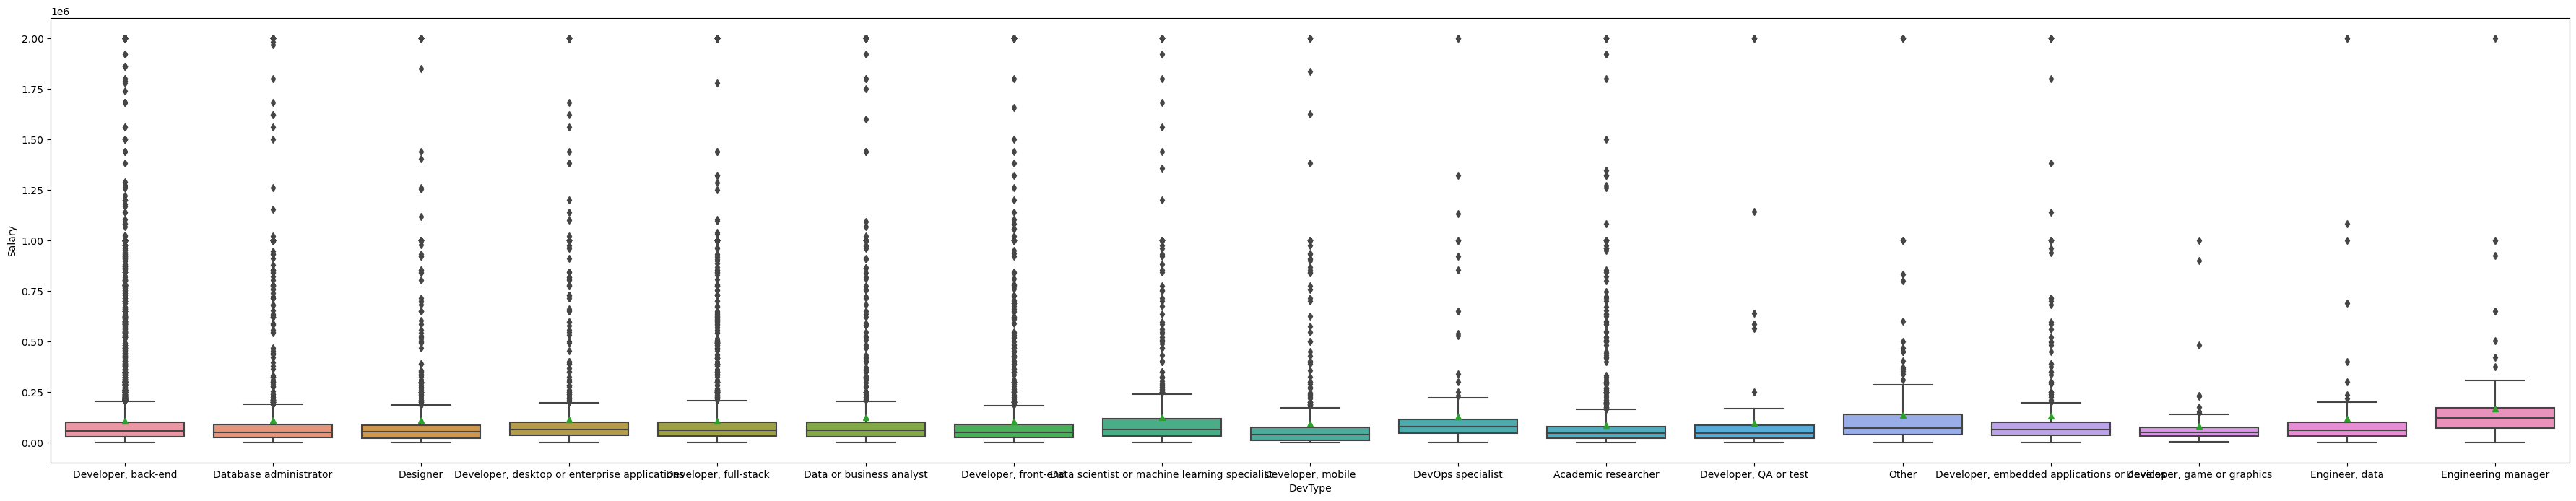

In [421]:
plt.figure(figsize=(45,8))
sns.boxplot(x=df['DevType'], y='Salary', data=df, showmeans=True)

<AxesSubplot:xlabel='Country', ylabel='Salary'>

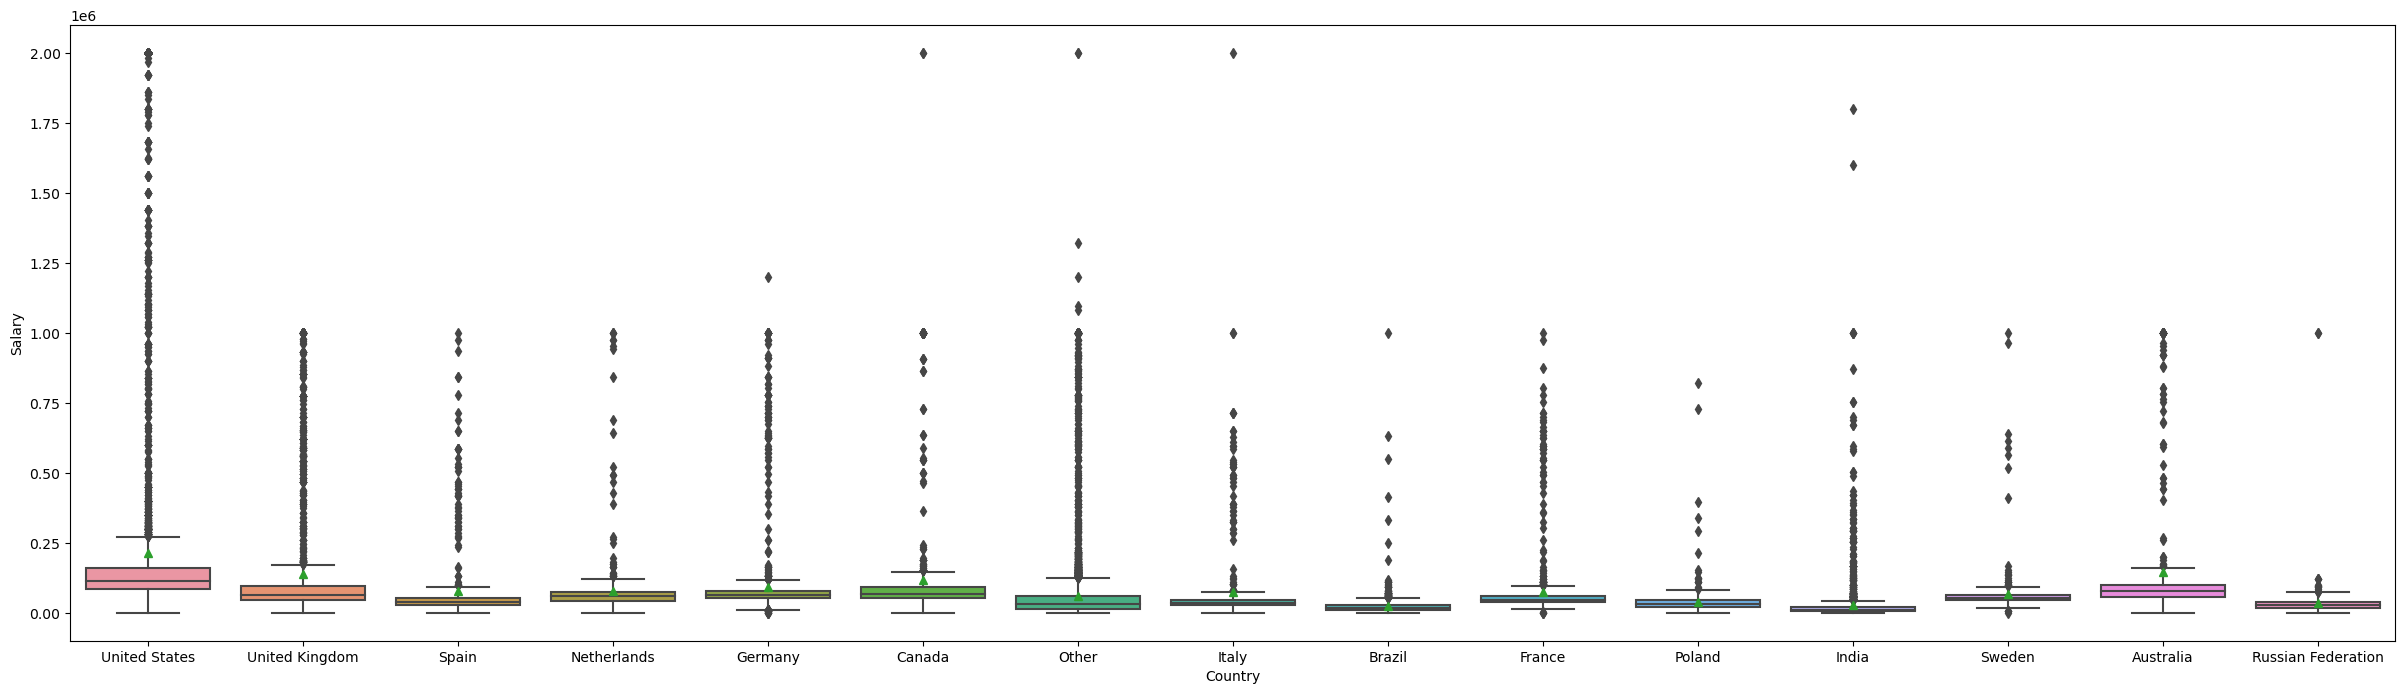

In [422]:
plt.figure(figsize=(30,8))
sns.boxplot(x=df['Country'], y='Salary', data=df, showmeans=True)

We classified, in each DevType and Country, categories that had way too few examples as 'Other'. However, by choice of the business, it is not desired to have a generic category called Other: they want that every instance, not only in Country but also in DevType, to exist within a "realistic" category.

So, the exit is to filter out every instance belonging to the 'Other' category in both Country and DevType.

Also, the boxplots above show that there are a lot of outliers regarding the Salary. After careful consideration, communication with the business and considering a simple yet effective solution, we will be removing from the analysis Salaries above 250k and below 5k. 

In [50]:
df = df[df['Salary'] <= 250000]
df = df[df['Salary'] >= 5000]
df = df[df['Country'] != 'Other']
df = df[df['DevType'] != 'Other']
df = df[df['DevType'] != 'Other (please specify):']

In [18]:
df

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,116000.0
9,United Kingdom,Database administrator,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,32315.0
10,United Kingdom,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,40070.0
11,Spain,Designer,Some college/university study without earning ...,7,14268.0
12,Netherlands,Designer,"Secondary school (e.g. American high school, G...",20,38916.0
...,...,...,...,...,...
64113,United States,"Developer, back-end",Some college/university study without earning ...,15,225000.0
64116,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,150000.0
64122,United States,"Developer, front-end","Associate degree (A.A., A.S., etc.)",4,70000.0
64127,United States,Data or business analyst,"Other doctoral degree (Ph.D., Ed.D., etc.)",12,140000.0


Now regarding the 'YearsCodePro' feature, which represents the number of years the professional has been working professionally with developing and/or coding. Checking the distribution, we can see that there are two categories in which the feature can fall in: coding for Less then 1 year and coding for More then 50 years. For the sake of simplicity, we are going to consider the following: If the developer falls in the Less than 1 year category, the value 0.5 (average between 0 and 1 years) is associated with them. If More than 50 years, the value 50 is returned. These are considerations made with the business and are logically acceptable.

In [425]:
df["YearsCodePro"].value_counts()

3                     1962
2                     1806
5                     1706
4                     1573
6                     1252
10                    1177
7                     1026
8                      998
1                      879
12                     669
Less than 1 year       653
15                     612
20                     573
9                      555
11                     435
13                     413
14                     347
16                     270
25                     248
18                     199
22                     195
17                     192
21                     178
19                     159
23                     142
30                     130
24                     115
26                      64
27                      63
28                      60
35                      58
32                      47
33                      35
34                      35
38                      33
31                      33
40                      31
2

In [51]:
def years_correction(col):
    if col == 'Less than 1 year':
        return 0.5
    if col == 'More than 50 years':
        return 50
    
    return float(col)

In [52]:
df["YearsCodePro"] = df.apply(lambda x: years_correction(x.YearsCodePro), axis=1)

In [21]:
df

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13.0,116000.0
9,United Kingdom,Database administrator,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4.0,32315.0
10,United Kingdom,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2.0,40070.0
11,Spain,Designer,Some college/university study without earning ...,7.0,14268.0
12,Netherlands,Designer,"Secondary school (e.g. American high school, G...",20.0,38916.0
...,...,...,...,...,...
64113,United States,"Developer, back-end",Some college/university study without earning ...,15.0,225000.0
64116,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,150000.0
64122,United States,"Developer, front-end","Associate degree (A.A., A.S., etc.)",4.0,70000.0
64127,United States,Data or business analyst,"Other doctoral degree (Ph.D., Ed.D., etc.)",12.0,140000.0


Let's now study the feature related to the Education Level ('EdLevel'). As we can see below, there are multiple types of education level in our dataset. We will segment the categories into 4 categories. These categories take into account the four main levels of education a professional can have.

In [429]:
df["EdLevel"].value_counts()

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          9592
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       4899
Some college/university study without earning a degree                                2069
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     715
Other doctoral degree (Ph.D., Ed.D., etc.)                                             711
Associate degree (A.A., A.S., etc.)                                                    707
Professional degree (JD, MD, etc.)                                                     246
I never completed any formal education                                                  60
Primary/elementary school                                                               48
Name: EdLevel, dtype: int64

In [53]:
def edu_level_adjust(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

In [54]:
df["EdLevel"] = df.apply(lambda x: edu_level_adjust(x.EdLevel), axis=1)

In [24]:
df

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end",Bachelor’s degree,13.0,116000.0
9,United Kingdom,Database administrator,Master’s degree,4.0,32315.0
10,United Kingdom,"Developer, back-end",Bachelor’s degree,2.0,40070.0
11,Spain,Designer,Less than a Bachelors,7.0,14268.0
12,Netherlands,Designer,Less than a Bachelors,20.0,38916.0
...,...,...,...,...,...
64113,United States,"Developer, back-end",Less than a Bachelors,15.0,225000.0
64116,United States,"Developer, back-end",Bachelor’s degree,6.0,150000.0
64122,United States,"Developer, front-end",Less than a Bachelors,4.0,70000.0
64127,United States,Data or business analyst,Post grad,12.0,140000.0


In [25]:
df.isnull().sum()

Country         0
DevType         0
EdLevel         0
YearsCodePro    0
Salary          0
dtype: int64

In [26]:
df.head()

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end",Bachelor’s degree,13.0,116000.0
9,United Kingdom,Database administrator,Master’s degree,4.0,32315.0
10,United Kingdom,"Developer, back-end",Bachelor’s degree,2.0,40070.0
11,Spain,Designer,Less than a Bachelors,7.0,14268.0
12,Netherlands,Designer,Less than a Bachelors,20.0,38916.0


We have all our features set up, with them being Country, DevType, EdLevel and YearsCodePro. Now, let's study how to encode our categorical features and check the correlattion between the features when they are encoded.

Since EdLevel does not have many levels (4) we will be applying OneHotEncoder to it. However, Country and DevType have a lot of levels and, if we applied OneHotEncoder to it, it would create way to many features, incresaing computation complexity, increasing overfitting possibility and generating too much sparsity. So, with Country and DevType, we will be using LeaveOneOutEncoder, which, in this case of a regression problem, fits an encoder that associates to each category the mean value of the output without considering the current row value when fitting the encoder with training data. This encoding method is a good choice when dealing with features that have a lot of levels.

In [35]:
df = df.reset_index().drop(columns=["index"])

enc = OneHotEncoder().fit(df[['EdLevel']])

enc_data = pd.DataFrame(enc.transform(df[['EdLevel']]).toarray())

New_df = df.join(enc_data).drop(columns=["EdLevel"])

original_df_cols = list(filter(lambda x: x not in ["EdLevel"], list(df.columns)))

New_df.columns = original_df_cols + list(enc.get_feature_names_out(['EdLevel']))

looe = LeaveOneOutEncoder(cols=['Country', 'DevType'])
New_df[['Country', 'DevType']] = looe.fit_transform(New_df[['Country', 'DevType']], New_df['Salary'])


In [36]:
New_df

,Country,DevType,YearsCodePro,Salary,EdLevel_Bachelor’s degree,EdLevel_Less than a Bachelors,EdLevel_Master’s degree,EdLevel_Post grad
0,116058.396181,74518.879963,13.0,116000.0,1.0,0.0,0.0,0.0
1,68147.920757,70702.112687,4.0,32315.0,0.0,0.0,1.0,0.0
2,68143.956033,74528.962289,2.0,40070.0,1.0,0.0,0.0,0.0
3,40848.859736,67624.814815,7.0,14268.0,0.0,1.0,0.0,0.0
4,61137.977492,67598.732275,20.0,38916.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
19042,116042.007668,74504.406453,15.0,225000.0,0.0,1.0,0.0,0.0
19043,116053.284168,74514.365290,6.0,150000.0,1.0,0.0,0.0,0.0
19044,116065.312434,69417.251787,4.0,70000.0,0.0,1.0,0.0,0.0
19045,116054.787701,74123.771930,12.0,140000.0,0.0,0.0,0.0,1.0


Applying MinMaxScaler to the data in order to study more correctly the correlation between the features and output. We will be using the Spearman correlation coefficient since we are not going to assume that every relation between features and feature with output is necessarily linear.

In [38]:
columns_df = New_df.columns
New_df = pd.DataFrame(MinMaxScaler().fit_transform(New_df), columns=columns_df)
New_df

,Country,DevType,YearsCodePro,Salary,EdLevel_Bachelor’s degree,EdLevel_Less than a Bachelors,EdLevel_Master’s degree,EdLevel_Post grad
0,0.999832,0.224589,0.252525,0.453052,1.0,0.0,0.0,0.0
1,0.495374,0.167140,0.070707,0.111475,0.0,0.0,1.0,0.0
2,0.495333,0.224741,0.030303,0.143129,1.0,0.0,0.0,0.0
3,0.207938,0.120822,0.131313,0.037813,0.0,1.0,0.0,0.0
4,0.421566,0.120430,0.393939,0.138419,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
19042,0.999660,0.224371,0.292929,0.897958,0.0,1.0,0.0,0.0
19043,0.999778,0.224521,0.111111,0.591830,1.0,0.0,0.0,0.0
19044,0.999905,0.147801,0.070707,0.265294,0.0,1.0,0.0,0.0
19045,0.999794,0.218642,0.232323,0.551013,0.0,0.0,0.0,1.0


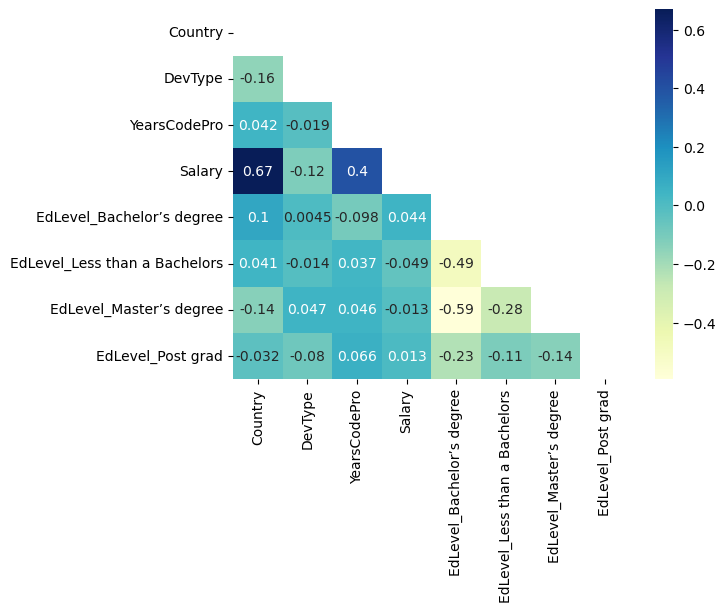

In [39]:
mask = np.triu(np.ones_like(New_df.corr()))
dataplot=sns.heatmap(New_df.corr(method='spearman'), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

By analyzing the heatmap above, one can see that Salary, our output, has a considerable correlation with the Country, what makes sense since the salary paid to developers varies a lot from country to country. Also, Salary has some correlation (very light correlation) with YearsCodePro. All these two cases mentioned are associated with a correlation that when one variable increases, the other also increases since the spearman coefficient is positive.

Also, when checking the one hot encoded variable (education level) that opens up in four features (dummy), one can see that there is some correlation among them, specially among Bachelor Degree, Less than Bachelor Degree and Master's Degree. However, these values (for example -0.49 and -0.59), cannot be considered as strong correlations, since literature points out that strong correlation coefficients, in absolute, are above, approximately, 0.7.

Now that we have our features and encoding processes defined, let's dive into testing different models. Since there are a lot of encoding processes and also the need to normalize our inputs, we are creating a pipeline using sklearn's ColumnTransformer and make_pipeline functions. For the features Country and DevType, we are using LeaveOneOutEncoder. For EdLevel we are using OneHotEncoder. Also, before fitting or predicting with a regressor, we are also applying MinMaxScaler, mainly in this initial algorithm exploration since we are testing models that require that the features are in the same scale, such as k-NN regressor and Support Vector Machine Regressor.

In [55]:
X = df.drop(columns=["Salary"])
y = df["Salary"]

In [61]:
columns_trans = ColumnTransformer(
    transformers=[
        ('leaveoneout', LeaveOneOutEncoder(), ['Country', 'DevType']),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['EdLevel'])
    ],
    remainder='passthrough'
)

preprocessor = make_pipeline(
    columns_trans,
    MinMaxScaler(),
    RandomForestRegressor() #or any other regressor
)

Let's explore five regressors: Raqndom Forest, XGBoost, k-NN, SVM and Decision Tree. Using cross-validation with 3 folds and applying all transformations within each fold so there is not any data leakeage occuring. The metrics we are going to use to compare algorithms are Mean Absolute Error (MAE), R2 and Mean Absolute Percentage Error (MAPE).

In [62]:
# Assuming df is your DataFrame
x_input = df.drop(['Salary'], axis=1)
y_output = df[['Salary']]


X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.20, stratify=df["DevType"])

# Define the number of folds (k)
k = 3

# Initialize your KFold object
kf = KFold(n_splits=k, random_state=42, shuffle=True)

# Define a list of models to evaluate
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "XGBoostRegressor": XGBRegressor(),
    "SVMRegressor": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor()
}

model_metrics = {}

for model_name, model in models.items():
    fold_metrics = {
        "MAE": [],
        "MAPE": [],
        "R2": []
    }

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        preprocessor = make_pipeline(
            columns_trans,
            MinMaxScaler(),
            model
        )

        preprocessor.fit(X_train_fold, y_train_fold.values.ravel())
        
        y_pred = preprocessor.predict(X_val_fold)

        mse = mean_squared_error(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        rmse = np.sqrt(mse)

        fold_metrics["MAE"].append(mae)
        fold_metrics["MAPE"].append(mape)
        fold_metrics["R2"].append(r2)

    mean_metrics = {
        "MAE": np.mean(fold_metrics["MAE"]),
        "MAPE": np.mean(fold_metrics["MAPE"]),
        "R2": np.mean(fold_metrics["R2"]),
    }

    model_metrics[model_name] = mean_metrics

Below we can check the results from the CV. Surprisingly, k-NN regressor had the best results when we compared all algorithms using their respective standard hyperparameters, with k-NN regressor having the following results in the CV:

MAE = 22151.6

R2 = 0.53

MAPE = 41%

In [54]:
model_metrics

{'RandomForestRegressor': {'MAE': 24548.96880156933,
  'MAPE': 0.5369833598105088,
  'R2': 0.5096774887938401},
 'KNeighborsRegressor': {'MAE': 22151.57423377305,
  'MAPE': 0.4105488511050206,
  'R2': 0.535955470419482},
 'XGBoostRegressor': {'MAE': 26974.85827179266,
  'MAPE': 0.7334392130039555,
  'R2': 0.4613848407392906},
 'SVMRegressor': {'MAE': 36718.267967841726,
  'MAPE': 1.0379145129209404,
  'R2': -0.017203853797620683},
 'DecisionTreeRegressor': {'MAE': 25988.484226991317,
  'MAPE': 0.586835362451652,
  'R2': 0.4403236211619214}}

Let's then proceed with k-NN and do some fine tuning using GridSearch varying the k-NN hyperparameters n_neighbors, weights and p. For example, when we are increasing the number of neighbrs, we are increaing the regularization (lower number of neighbors have a higher chance to cause overfitting).

After applying the hyperparameter tuning, the results were:

n_neighbors = 30

p = 1

weights = 'uniform'

In [77]:
columns_trans = ColumnTransformer(
    transformers=[
        ('leaveoneout', LeaveOneOutEncoder(), ['Country', 'DevType']),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['EdLevel'])
    ],
    remainder='passthrough'
)

preprocessor = Pipeline([
    ('cols_transf', columns_trans),
    ('minmax', MinMaxScaler()),
    ('regressor', KNeighborsRegressor())
]
)

x_input = df.drop(['Salary'], axis=1)
y_output = df[['Salary']]

X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2, stratify=df["DevType"])

params = { 'regressor__n_neighbors': [2, 4, 5, 6, 10, 15, 30],
           'regressor__weights': ['uniform', 'distance'],
           'regressor__p': [1, 2]
         }


grid_search = GridSearchCV(preprocessor, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train.values.ravel())

print("\nBest Parameters according to Grid Search:", grid_search.best_params_)


Best Parameters according to Grid Search: {'regressor__n_neighbors': 30, 'regressor__p': 1, 'regressor__weights': 'uniform'}


Let's now proceed to train the model, using k-NN regressor, with the hyperparameters previously determined and the pipeline constructed.

In [103]:
x_input = df.drop(['Salary'], axis=1)
y_output = df[['Salary']]

columns_trans = ColumnTransformer(
    transformers=[
        ('leaveoneout', LeaveOneOutEncoder(), ['Country', 'DevType']),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['EdLevel'])
    ],
    remainder='passthrough'
)

preprocessor = make_pipeline(
    columns_trans,
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors = 30, p = 1, weights = 'uniform')
)

X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2, stratify=df["DevType"], random_state=42)

preprocessor.fit(X_train, y_train.values.ravel())
y_train['PREDICTED'] = preprocessor.predict(X_train)

Mean Squared Error =  19982.359241758
MAPE =  0.36694486973495827
R2 =  0.6227240612318674


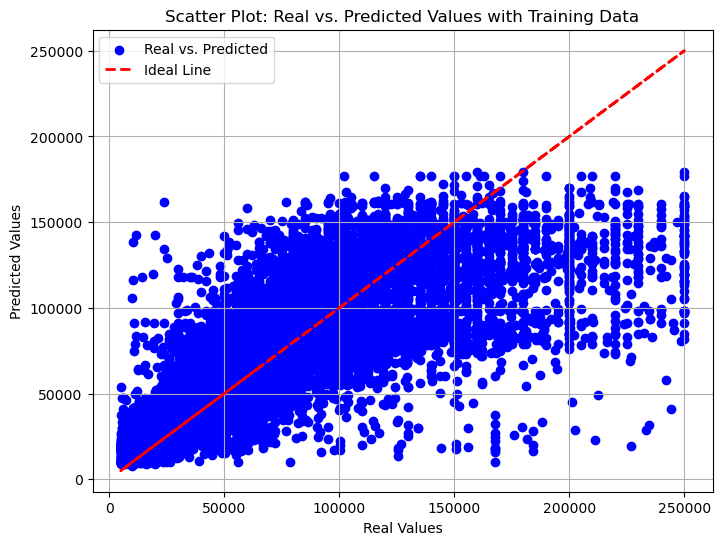

In [109]:
print("Mean Squared Error = ", mean_absolute_error(y_train['Salary'], y_train['PREDICTED']))
print("MAPE = ", mean_absolute_percentage_error(y_train['Salary'], y_train['PREDICTED']))
print("R2 = ", r2_score(y_train['Salary'], y_train['PREDICTED']))

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train['Salary'], y_train['PREDICTED'], color='blue', label='Real vs. Predicted')
plt.plot(y_train['Salary'], y_train['Salary'], color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Adding labels and title
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Real vs. Predicted Values with Training Data')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error =  21051.467480314957
MAPE =  0.38671731346885474
R2 =  0.5901963258868563


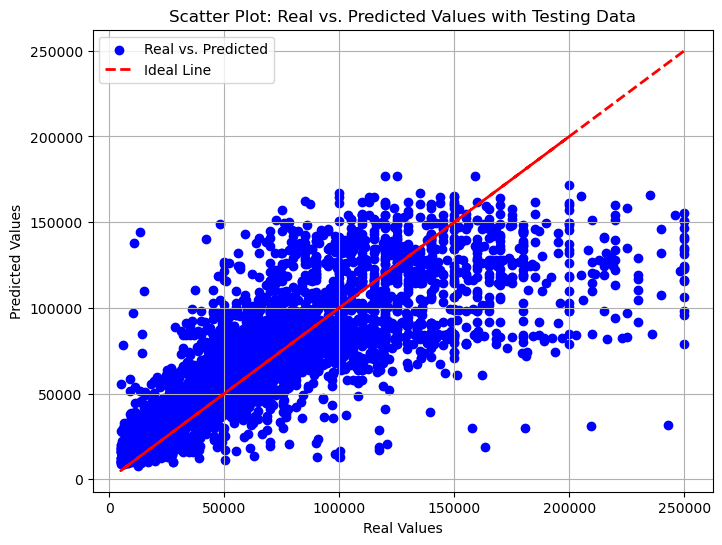

In [110]:
y_test['PREDICTED'] = preprocessor.predict(X_test)
print("Mean Squared Error = ", mean_absolute_error(y_test['Salary'], y_test['PREDICTED']))
print("MAPE = ", mean_absolute_percentage_error(y_test['Salary'], y_test['PREDICTED']))
print("R2 = ", r2_score(y_test['Salary'], y_test['PREDICTED']))

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test['Salary'], y_test['PREDICTED'], color='blue', label='Real vs. Predicted')
plt.plot(y_test['Salary'], y_test['Salary'], color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Adding labels and title
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Real vs. Predicted Values with Testing Data')
plt.legend()
plt.grid(True)
plt.show()

Conclusions:

We have built a model using k-NN Regressor to predict the Salary of a developer based on inputs such as their Country, Education Level, Type of development work and Years Working in the industry. The model built after hyperparameter tuning obtained a MAE = 21051 and MAPE = 38.67% based on the testing data. Looking at the MAPE, literature points out that a MAPE between 20 and 50% provides a regression characterized as "Reasonable forecasting" (Lewis (1982, p.40)), which is what the business requirements wanted: a reasonable prediction of the salary to work as an orientation in the HR compensation team study. However, an interesting observation that has to be made is that the model has more difficulty to predict Salaries above, approx., the 150k threshold, as we can see in the visuals above.